# Feature Selection

In this section we focus on selecting features that are important when predicting if a given person is a customer. Since one of our goals is to understand distinctive features of customers and respondents to the mailout campain, we will look for columns that not only explain most of the variance of the data sets (PCA) but also those features that are the most important when we want to predict if a given person is a customer.

In [1]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#clean data module
import clean_data

#supervised models functions
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


%matplotlib inline
#for reproducible results across multiple function calls
SEED = 42

In [73]:
clean_azdias = pd.read_csv('clean_azdias.csv')
clean_customers = pd.read_csv('clean_customers.csv')

The main question we answer in this notebook is: *What features are the most important when predicting if somebody is a customer?*

To answer this question, we set up a classification model and find which features are the most important in a prediction models like AdaBoosterClassifier and GradientBoostingClassifier. We concatenate the `clean_azdias` and `clean_customers` datasets, add a binary label `CUSTOMER` and drop duplicates.

In [74]:
clean_customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)
clean_customers['CUSTOMER'] = 1
clean_azdias['CUSTOMER'] = 0

azdias_and_customers = clean_azdias.append(clean_customers)
azdias_and_customers.drop_duplicates(inplace = True)

labels = azdias_and_customers['CUSTOMER']
X_model = azdias_and_customers.drop(['CUSTOMER'], axis = 1, inplace = False)

scaler = StandardScaler()
X_model_scaled = pd.DataFrame(scaler.fit_transform(X_model), columns = X_model.columns)

X_train, X_val, y_train, y_val = train_test_split(X_model_scaled, labels, stratify = labels, test_size=0.2)


In [78]:
def roc_time(model, X_train, y_train, X_test, y_test):
    "Fits model, predicts and outputs its AUROC score and time it took to train"
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elap = end - start
    return roc_score, time_elap

In [79]:
models = [("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED))]

results_reduced = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = roc_time(model, X_train, y_train, X_val, y_val)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    results_reduced["Time_in_sec"].append(time_)
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

,Model,AUCROC_score,Time_in_sec
0,GradientBoostingClassifier,0.928014,1434.9
1,AdaBoostClassifier,0.911891,479.387


In [106]:
gbc = models[0][1]

In [107]:
ada = models[1][1]

In [100]:
def feature_importances(model, model_name, feature_names, num_features):
    "Returns dataframe with num_feature most important Gini Importance information"
    feature_importance_values = model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Gini Importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('Gini Importance', ascending = False).reset_index(drop = True)
    
    feature_importances['Accumulated Importance'] = feature_importances['Gini Importance'].cumsum()
    
    return feature_importances

In [102]:
def feature_importances_barplot(model, model_name, feature_names, num_features):
    """
    Plots top num_feature importances for the given model
    """
    feature_importances = feature_importances(model, model_name, feature_names, num_features)
    fig = plt.figure(figsize=(12, 20))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['Gini Importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['Feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Gini Feature Importances ({model_name})')
    
    print(feature_importances)
    return feature_importances

In [ ]:
gbc_feature_importances = feature_importances(gbc, "GradientBoostingClassfier", X_model.columns, num_features=50)

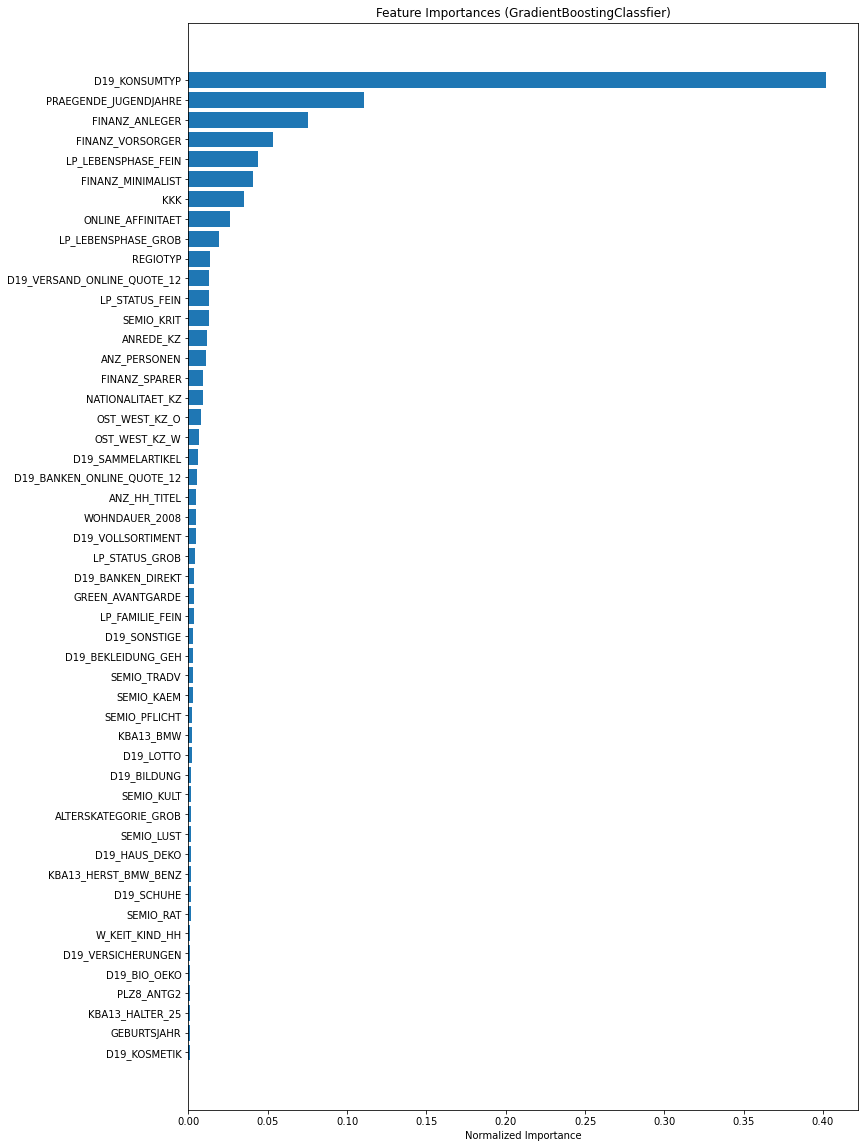

In [103]:
plot_feature_importances(gbc, "GradientBoostingClassfier", X_model.columns, num_features=50)

In [109]:
ada_feature_importances = feature_importances(ada, "AdaBoost", X_model.columns, num_features=50)

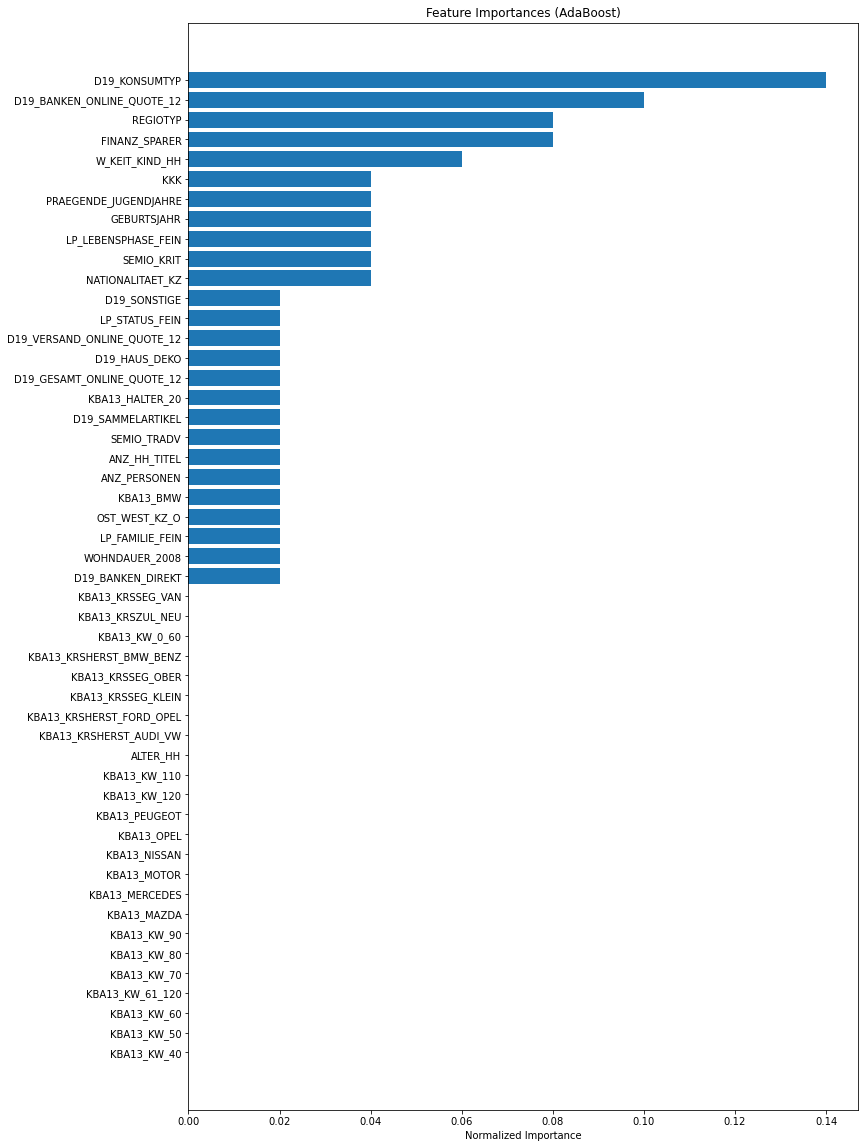

In [89]:
plot_feature_importances(ada, "AdaBoost", X_model.columns, num_features=50)

In [116]:
important_gbc_features = gbc_feature_importances[gbc_feature_importances['Accumulated Importance']<.99]['Feature'].values

In [117]:
important_ada_features = ada_feature_importances[ada_feature_importances['Accumulated Importance']<.99]['Feature'].values

We'll union the most important features of these two models and use them going forward. 

In [124]:
selected_fetures = set(important_ada_features).union(set(important_gbc_features))

Now we save our the data with these selected features.

In [ ]:
clean_azdias.drop(['CUSTOMER'], axis = 1)
clean_customers.drop(['CUSTOMER'], axis =1)

In [137]:
scaler = StandardScaler()
scaler.fit_transform(X_model[selected_features])

#feature-selected and standarized datasets
azdias_selected = pd.DataFrame(scaler.transform(clean_azdias[selected_features]), columns = selected_features)
customers_selected = pd.DataFrame(scaler.transform(clean_customers[selected_features]), columns = selected_features)

In [138]:
azdias_selected

,D19_KONSUMTYP,PRAEGENDE_JUGENDJAHRE,FINANZ_ANLEGER,FINANZ_VORSORGER,LP_LEBENSPHASE_FEIN,FINANZ_MINIMALIST,KKK,ONLINE_AFFINITAET,LP_LEBENSPHASE_GROB,REGIOTYP,...,KBA13_BMW,LP_FAMILIE_FEIN,KBA13_HERST_BMW_BENZ,D19_GESAMT_ONLINE_QUOTE_12,SEMIO_RAT,D19_VERSICHERUNGEN,D19_BILDUNG,D19_HAUS_DEKO,SEMIO_LUST,LP_FAMILIE_GROB
0,0.129553,1.303972,1.579102,-1.180141,0.280163,-1.587301,-0.708245,0.163377,0.181761,-0.773833,...,-0.207032,0.199581,0.768708,0.000375,1.370742,-0.598008,-0.350722,-0.538828,-1.238399,0.292585
1,1.354077,1.548692,-0.442863,-1.909635,-1.187507,-1.587301,-0.708245,-0.497129,-1.136824,-1.327351,...,0.795167,-0.804300,0.768708,-0.839574,0.163608,-0.598008,2.855336,-0.538828,-0.270896,-0.882324
2,1.354077,-0.164351,-0.442863,1.008340,-0.102284,0.548783,0.048687,-1.157635,-0.094744,0.042280,...,0.795167,-0.068117,-0.213373,-0.839574,-0.439959,-0.598008,-0.350722,-0.538828,-0.270896,-0.069122
3,-1.410699,-0.164351,-1.116851,0.278846,1.177073,0.548783,0.331170,1.484388,1.236629,0.333202,...,-1.209231,1.454431,-0.213373,1.563434,-1.043526,0.687249,2.855336,1.629290,-0.270896,1.467494
4,-0.373908,-1.387954,-0.442863,1.008340,-0.779820,-0.163245,1.370585,-1.157635,-0.873107,0.333202,...,0.795167,-0.804300,-0.213373,1.563434,1.974309,1.972506,-0.350722,-0.538828,-1.238399,-0.882324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737283,-1.410699,1.303972,1.579102,-1.180141,-1.269044,-1.587301,0.331170,1.484388,-1.136824,0.333202,...,-1.209231,-0.804300,-1.195455,1.563434,0.163608,-0.598008,-0.350722,-0.105205,-1.722150,-0.882324
737284,1.354077,0.325090,-0.442863,-0.450647,-1.269044,-0.163245,0.331170,-0.497129,-1.136824,1.440238,...,-0.207032,-0.804300,-0.213373,-0.839574,0.163608,-0.598008,-0.350722,-0.538828,1.180357,-0.882324
737285,-0.719505,1.303972,1.579102,-1.180141,-0.102284,-0.875273,0.331170,0.163377,-0.094744,0.333202,...,-1.209231,-0.068117,1.750789,-0.839574,1.974309,1.972506,-0.350722,2.062913,-0.754647,-0.069122
737286,1.354077,1.303972,1.579102,-0.450647,0.932461,-1.587301,1.370585,0.163377,0.972912,1.440238,...,-0.207032,1.203461,0.768708,-0.839574,0.767175,-0.598008,-0.350722,-0.538828,-0.754647,1.467494


In [139]:
azdias_selected.to_csv('azdias_selected.csv', index=False)
customers_selected.to_csv('customers_selected.csv', index=False)